In [26]:
# 12 hrs 48 mins
import os

i_fp = open('data/weights.txt','w')
i_fp.close()

NUM_MODELS = 100
for i in range(NUM_MODELS):
    i_fp = open('iteration.txt','w')
    i_fp.write(str(i))
    i_fp.close()
    os.system('''cd C:/Users/monte/Documents/Memoria & ./py310tf210./Scripts/activate.ps1 & cd src/5.1.Optimization & python create_model_and_train.py''')


# Data & Imports

In [1]:
# time meausre
import time
import math
start_time = time.time()

def print_time(execution_time):
    hours = int(math.floor(int(execution_time)/3600))
    minutes = int(math.floor((execution_time/3600-hours)*60))
    seconds = execution_time%60
    print("--- Total: %i hours, %i minutes, %f seconds  ---" % (hours,minutes,seconds))

In [196]:
import keras
import autokeras as ak
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# constants
#path = 'C:/Users/Asus/Documents/2023_2/Memoria/src'
path = 'C:/Users/Monte/Documents/Memoria/src'

# seeds
global_seed = 19
# np.random.seed(seed=global_seed) # seed gets seted by statement below
keras.utils.set_random_seed(global_seed)
tf.config.experimental.enable_op_determinism()

# Ostar
O_df = pd.read_csv(path+'/Data/o_spectral_lines_trim.csv')
# Bstar
B_df = pd.read_csv(path+'/Data/b_spectral_lines_trim.csv')
# Observed spectra
Obs_df = pd.read_csv(path+'/Data/observed_spectral_lines_trim_v2.csv')

In [197]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

target = ['temperature','g','v']


X = B_df.drop(target,axis = 1)
Y = B_df[target]
X_obs = Obs_df.drop(target+['HD','date','time'],axis=1)
Y_obs = Obs_df[target]

X = np.random.normal(loc=0, scale=0.01, size=X.shape) + X
y_scaler = MinMaxScaler()

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=global_seed)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.75, test_size=0.25, random_state=global_seed)

y_scaler = y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)
y_obs = y_scaler.transform(Y_obs.values)

formatted_x_train = np.expand_dims(x_train, axis=2) #This step it's very important an CNN will only accept this data shape
formatted_x_val = np.expand_dims(x_val, axis=2)
formatted_x_test = np.expand_dims(x_test, axis=2)
formatted_x_obs = np.expand_dims(X_obs, axis=2)


c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [34]:
# Density plot function

# https://kdepy.readthedocs.io/en/latest/examples.html#minimal-working-example-with-options
from KDEpy import FFTKDE
from sklearn.neighbors import KernelDensity
import numpy as np

measure = ['Temperature','log g', 'v sini']
measure_unit = ['[K]', '[u]', '[km/s]']

def SKL_density_plot(data, ax,low_bound=None,up_bound=None,title='', color='black',alpha=1,label='',kernel='gaussian', bw='silverman',linewidth=1):
  
	if low_bound != None and up_bound != None:
		bw = FFTKDE(bw=bw, kernel='gaussian').fit(data).bw
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		data = np.concatenate((data, 2 * low_bound - data, 2 * up_bound - data))
		kde = KernelDensity(bandwidth=kde.bandwidth_, kernel=kernel).fit(data.reshape(-1,1))
		x = np.linspace(low_bound,up_bound,1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		plot_y = y[np.where((x>=low_bound) & (x<=up_bound))] # Set the KDE to zero outside of the domain
		plot_x = x[np.where((x>=low_bound) & (x<=up_bound))]  # Set the KDE to zero outside of the domain
		plot_y = plot_y * 3  # Double the y-values to get integral of ~1
		ax.plot(plot_x, plot_y, label=label,color=color,alpha=alpha,linewidth=linewidth)
		return x, y, kde
	else:
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		x=np.linspace(data.min(),data.max(),1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		ax.plot(x, y, label=label,color=color,alpha=alpha)
		return x, y, kde

# AutoModel

In [5]:
from keras_tuner.engine import hyperparameters as hp

# convBlock
conv_kernel_size = hp.Choice("kernel_size", [2,3,5],)
conv_num_layers = hp.Choice("conv_layers", [2,3],)
conv_num_blocks = hp.Choice("conv_blocks", [2,3],)
conv_filters = hp.Choice("filters", [32,64,128,256,512],)

# # DenseBlock
dense_num_layers = hp.Choice("dense_layers", [2,3])
dense_units = hp.Choice("dense_units", [128,256,384,512])

# RegressionHead
# head_dropout = hp.Float(
#                 'dropout_head',
#                 min_value=0.0,
#                 max_value=0.5,
#                 default=0.25,
#                 step=0.05,
#             )

input = ak.Input()
conv = ak.ConvBlock(
  	kernel_size=conv_kernel_size,
  	num_blocks=conv_num_blocks,
  	num_layers=conv_num_layers,
  	filters=conv_filters,
  	max_pooling=True,
		separable=False,
  	#dropout=conv_dropout,
)(input)
dense = ak.DenseBlock(
  	num_layers=dense_num_layers, 
  	num_units=dense_units, 
  	use_batchnorm=False, 
  	#dropout=dense_dropout
)(conv)
regression_output = ak.RegressionHead(
  	output_dim=3, 
   	loss="mse", 
    metrics=["mae"], 
    #dropout=head_dropout,
)(dense)


def generateAutoModel():
  return ak.AutoModel(
	inputs=input,
	outputs=regression_output,
	max_trials=300,
	loss='mse',
	metrics = 'mae',
	tuner='greedy',
	overwrite=False,
	seed=global_seed,
	max_model_size=None,
	directory='./greedy',
 	project_name='greedy_approach')



# Single Model

In [6]:
# set timer
curr_time = time.time()

In [7]:
# 6 hrs, 15 min 100 modelos bayesian
# 28 hrs 400 modelos bayesian
# 15 hrs 118 modelos greedy
# 7 hrs 73 modelos greedy
model = generateAutoModel()
model.fit(formatted_x_train, y_train,validation_data=(formatted_x_val, y_val), epochs=20)



Trial 300 Complete [00h 05m 50s]
val_loss: 0.00449632341042161

Best val_loss So Far: 0.004377804230898619
Total elapsed time: 8d 02h 47m 58s
Epoch 1/20
459/459 [==============================] - 21s 36ms/step - loss: 0.0829 - mae: 0.2299 - val_loss: 0.0377 - val_mae: 0.1432
Epoch 2/20
459/459 [==============================] - 16s 35ms/step - loss: 0.0227 - mae: 0.1061 - val_loss: 0.0160 - val_mae: 0.0913
Epoch 3/20
459/459 [==============================] - 16s 35ms/step - loss: 0.0161 - mae: 0.0876 - val_loss: 0.0117 - val_mae: 0.0759
Epoch 4/20
459/459 [==============================] - 16s 35ms/step - loss: 0.0139 - mae: 0.0811 - val_loss: 0.0103 - val_mae: 0.0713
Epoch 5/20
459/459 [==============================] - 16s 35ms/step - loss: 0.0128 - mae: 0.0778 - val_loss: 0.0094 - val_mae: 0.0661
Epoch 6/20
459/459 [==============================] - 16s 35ms/step - loss: 0.0108 - mae: 0.0699 - val_loss: 0.0089 - val_mae: 0.0627
Epoch 7/20
459/459 [==============================] - 

INFO:tensorflow:Assets written to: ./greedy\greedy_approach\best_model\assets


INFO:tensorflow:Assets written to: ./greedy\greedy_approach\best_model\assets


In [8]:
# execution time print
print_time(float(time.time() - curr_time))

--- Total: 5 hours, 33 minutes, 12.409971 seconds  ---


In [9]:
exp = model.export_model()
exp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 139, 1)]          0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 139, 1)           0         
 t32)                                                            
                                                                 
 conv1d (Conv1D)             (None, 138, 256)          768       
                                                                 
 conv1d_1 (Conv1D)           (None, 137, 512)          262656    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 137, 512)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 137, 512)          0     

In [10]:
# Evaluate the best model with testing data.
evaluation = model.evaluate(formatted_x_test, y_test)

print('loss: %.3f  MAE:%.3f'% (evaluation[0],evaluation[1]))

153/153 [==============================] - 2s 11ms/step - loss: 0.0043 - mae: 0.0375
loss: 0.004  MAE:0.037


In [11]:
predictions = model.predict(formatted_x_test)

153/153 [==============================] - 1s 7ms/step


In [12]:
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((predictions[:,i]-y_test[:,i])**2))
  maes.append(np.mean(np.abs(predictions[:,i]-y_test[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.010  MAE:0.066
log g -       loss: 0.003  MAE:0.034
v -           loss: 0.000  MAE:0.012


In [13]:
# / TODO: error de perdida para cada parametro
# / TODO: grafica de valor esperado vs prediccion para espectro observado
# TODO: fijar casos borde para espectros observados(grafica)
# TODO: agregar chi a la tabla

### Prediccion de datos de testing (modelo unico)

In [14]:
predictions = y_scaler.inverse_transform(predictions)

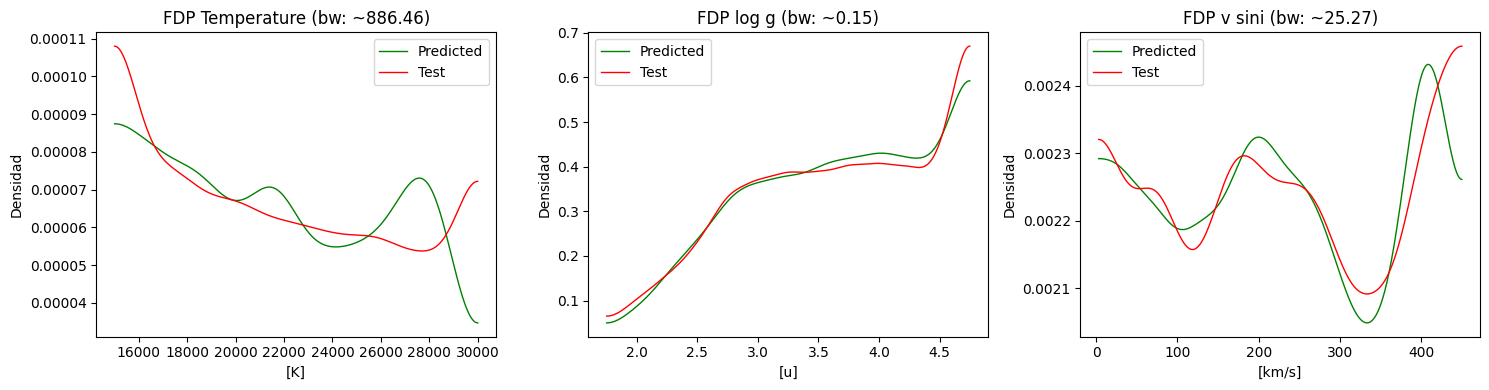

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

for i, featureName in enumerate(target):
	x, y, kde = SKL_density_plot(predictions[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',label='Predicted')
	x, y, kde = SKL_density_plot(y_scaler.inverse_transform(y_test)[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color='red',label='Test')
	measure = ['Temperature','log g', 'v sini']
	measure_unit = ['[K]', '[u]', '[km/s]']
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel('Densidad')
	axes[i].set_title('FDP '+measure[i]+' (bw: ~%.2f'%(kde.bandwidth_)+')')
	axes[i].legend()

plt.legend()
plt.tight_layout();
plt.show()

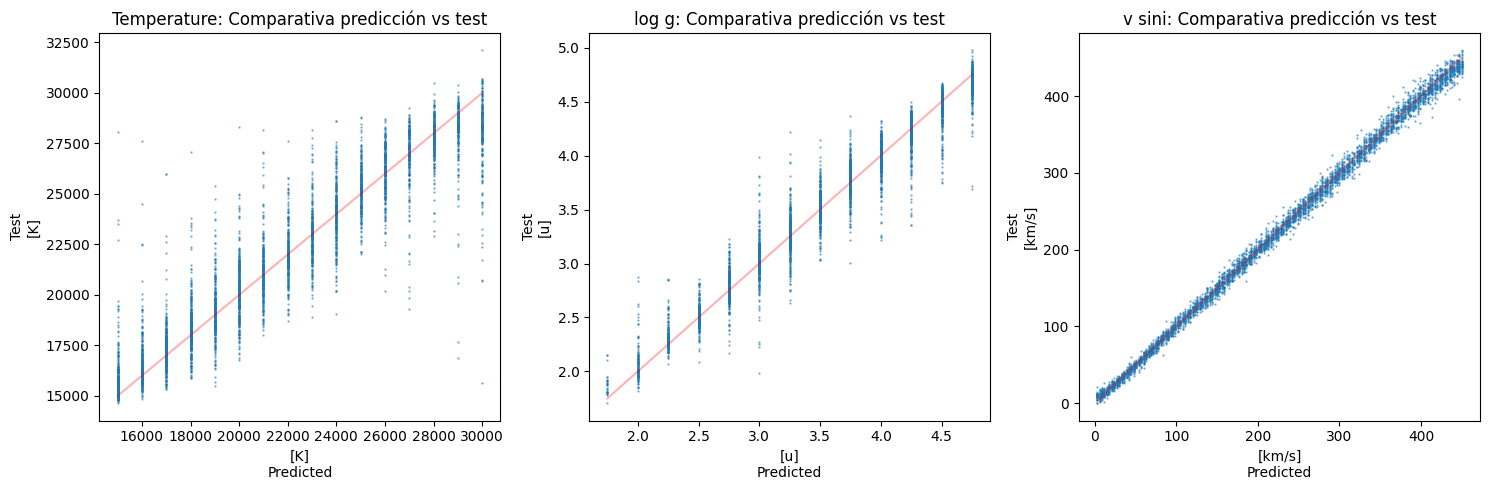

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=predictions[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Comparativa predicción vs test')
 
plt.tight_layout();
plt.show()

c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


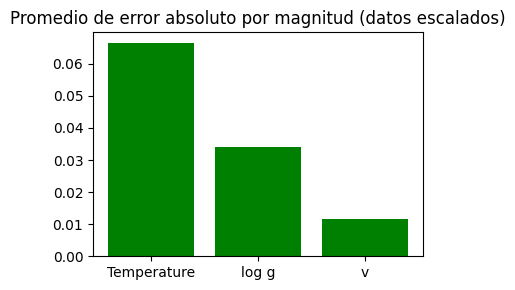

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
x_data = ['Temperature','log g','v']

diff = np.mean(np.abs(y_scaler.transform(predictions)-y_test),axis=0)
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error absoluto por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


In [18]:
#data formatting
inverse_y_test = y_scaler.inverse_transform(y_test)
rel_error = np.abs(predictions-inverse_y_test)*(1/inverse_y_test)*100
abs_error = np.abs(predictions-inverse_y_test)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_test[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_test[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_test[:,2],0)]

table_formatted_temperature_pred = [str(round(i)) for i in predictions[:,0]]
table_formatted_log_g_pred = [str(round(i,2)) for i in predictions[:,1]]
table_formatted_v_pred = [str(round(i)) for i in predictions[:,2]]

table_formatted_temperature_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(round(i,2))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [19]:
# table plot
results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temp':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,

                    })
results.head(10)

,Temperatura,Prediccion_Temp,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel)
0,17000,17908,908 (5.3%),3.25,3.17,0 (2.5%),246,244,2 (0.7%)
1,18000,16847,1153 (6.4%),2.75,2.71,0 (1.4%),285,285,0 (0.0%)
2,30000,27662,2338 (7.8%),3.75,3.62,0 (3.5%),267,265,2 (0.7%)
3,23000,20944,2056 (8.9%),2.5,2.38,0 (4.8%),63,62,1 (1.2%)
4,19000,19843,843 (4.4%),3.0,3.01,0 (0.4%),126,126,0 (0.3%)
5,17000,16922,78 (0.5%),4.5,4.27,0 (5.0%),156,168,12 (7.7%)
6,28000,23637,4363 (15.6%),3.25,2.97,0 (8.6%),450,459,9 (2.0%)
7,22000,21008,992 (4.5%),4.0,4.08,0 (2.1%),285,289,4 (1.6%)
8,23000,23228,228 (1.0%),3.0,2.93,0 (2.2%),30,26,4 (12.9%)
9,23000,22162,838 (3.6%),4.5,4.47,0 (0.7%),153,157,4 (2.4%)


### Datos observados vs predicción de modelo único

In [20]:
predictions = model.predict(formatted_x_obs)

3/3 [==============================] - 0s 8ms/step


In [21]:
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((predictions[:,i]-y_obs[:,i])**2))
  maes.append(np.mean(np.abs(predictions[:,i]-y_obs[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.245  MAE:0.421
log g -       loss: 0.040  MAE:0.166
v -           loss: 0.027  MAE:0.106


In [22]:
predictions = y_scaler.inverse_transform(predictions)

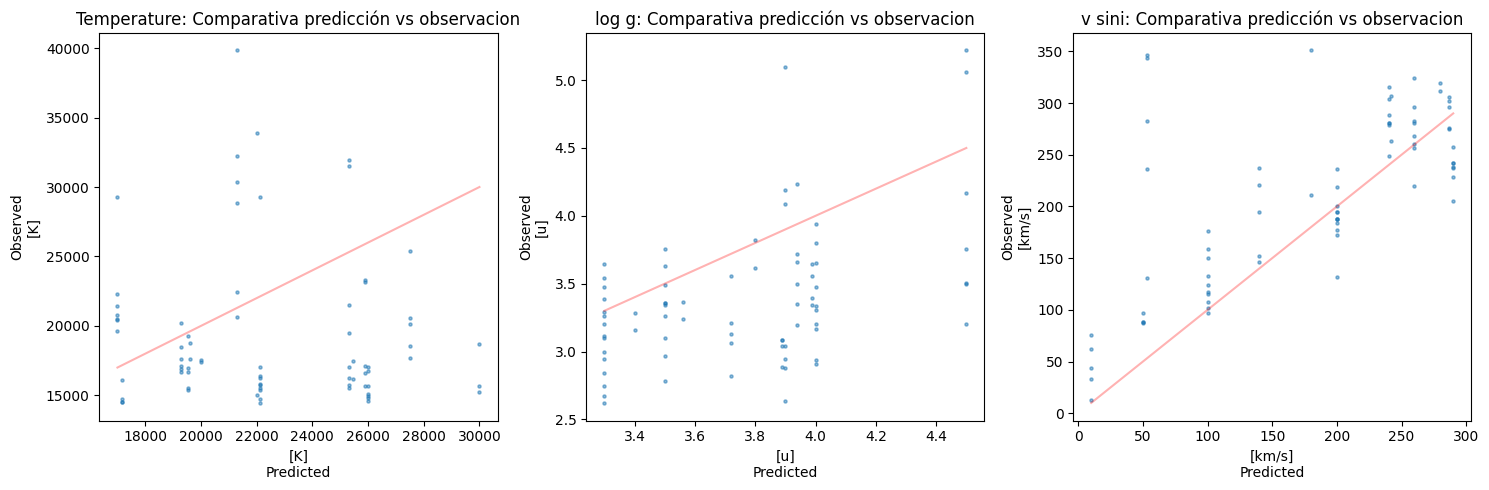

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_obs)[:,i].min(), y_scaler.inverse_transform(y_obs)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_obs)[:,i],y=predictions[:,i],s=5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Observed\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Comparativa predicción vs observacion')
 
plt.tight_layout();
plt.show()

In [291]:
# xi
def xi(obs,sint):
  return np.sum((obs - sint)**2/sint)
def get_closest_spectra_line(index):
  obs = formatted_x_obs[index]
  min_dist = np.inf
  min_dist_index = -1
  for i, sint in enumerate(x):
    
    d = xi(obs, sint)
    if d < min_dist:
      min_dist = d
      min_dist_index = i
      
  return min_dist, min_dist_index

In [292]:
# find closest parameters
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx
  
nearest = []
for obs_parameters in Y_obs.to_numpy():
	neighbor = []
	for param_index in range(len(target)):
		v, _ = find_nearest(Y.iloc[:,param_index].values,obs_parameters[param_index])
		neighbor.append(v)
	nearest.append(neighbor)
 
nearest_index = []
for neighbor in nearest:
	nearest_index.append(Y[(Y.temperature == neighbor[0]) & (Y.g == neighbor[1]) & (Y.v == neighbor[2])].index[0])

In [26]:
#data formatting
inverse_y_obs = y_scaler.inverse_transform(y_obs)
rel_error = np.abs(predictions-inverse_y_obs)*(1/inverse_y_obs)*100
abs_error = np.abs(predictions-inverse_y_obs)
#close = np.array([get_closest_spectra_line(index) for index in range(len(X_obs))])[:,0]

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_obs[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_obs[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_obs[:,2],0)]

table_formatted_temperature_pred = [str(round(i)) for i in predictions[:,0]]
table_formatted_log_g_pred = [str(round(i,2)) for i in predictions[:,1]]
table_formatted_v_pred = [str(round(i)) for i in predictions[:,2]]

table_formatted_temperature_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(round(i,2))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

# xi es la distancia entre el espectro observado y el espectro sintetico que tiene parámetros más cercanos a la estrella
table_formatted_xi = [xi(obs,sint) for obs, sint in zip(formatted_x_obs,X.iloc[nearest_index].to_numpy())]


In [27]:
# tabla de resultados modelo unico sobre datos observados

results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temp':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
  'paramCloseXi': table_formatted_xi
                    })
Obs_df[['HD','date','time']].join(results).set_index('HD').head(60)

,date,time,Temperatura,Prediccion_Temp,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel),paramCloseXi
HD,,,,,,,,,,,,
33328,2012-11-13,05-37-18,19526,16677,2849 (14.6%),3.3,3.26,0.04 (1.1%),287,274,13 (4.4%),100.145347
33328,2013-01-18,03-39-09,19526,15494,4032 (20.6%),3.3,3.65,0.35 (10.5%),287,276,11 (3.7%),88.230602
33328,2013-02-26,00-55-34,19526,19297,229 (1.2%),3.3,3.1,0.2 (6.0%),287,297,10 (3.4%),93.982720
33328,2015-02-25,23-58-07,19526,15384,4142 (21.2%),3.3,3.54,0.24 (7.4%),287,302,15 (5.2%),116.914635
33328,2015-02-26,00-19-03,19526,16957,2569 (13.2%),3.3,3.47,0.17 (5.3%),287,306,19 (6.6%),111.190865
35165,2014-03-20,23-53-54,17000,22324,5324 (31.3%),4.0,3.65,0.35 (8.7%),240,304,64 (26.8%),175.906493
35165,2014-03-21,00-14-49,17000,20507,3507 (20.6%),4.0,3.8,0.2 (5.0%),240,288,48 (20.1%),172.360638
35165,2014-03-21,00-35-18,17000,20398,3398 (20.0%),4.0,3.47,0.53 (13.2%),240,248,8 (3.5%),172.762155
35165,2015-11-14,04-22-43,17000,20764,3764 (22.1%),4.0,3.2,0.8 (20.0%),240,281,41 (17.0%),162.566641


In [28]:
# / TODO ponerle titulo a las cosas 
# / TODO mostrar tabla con datos sintéticos
# / TODO mostrar fdp datos sinteticos
# / TODO mostrar resultados prediccion de datos observados
# TODO distribucion predictiva de datos observados
# / TODO agregar ruido a todas las particiones de x 
# / TODO mostrar el error
# / TODO graficar comparativa de espectro observado con sintetico
# / TODO entender como se llego a la red nuronal
# / TODO volver a generar instancia de entrenamiento de autokeras

# Ensemble

In [29]:
# set timer
curr_time = time.time()

In [29]:
# write & read predictions functions
import numpy as np

def write_predictions(fp,predictions):
    for instance in predictions:
        t, g, v = instance
        fp.write(str(t)+' '+str(g)+' '+str(v)+'\n')
        
def read_predictions(fp,num_predictions):
    predictions = []
    lines = fp.readlines()
    for i in range(num_predictions):
        t, g, v = lines[i].split()
        predictions.append([float(t),float(g),float(v)])
    return np.array(predictions)

In [31]:
from scipy.sparse import coo_matrix
from sklearn.utils import resample
import gc
import threading


NUM_MODELS = 100
history = []

x_train_sparse = coo_matrix(x_train)

#file format
#weights_fp = open('./data/weights.txt','w+')
#weights_fp.close()


#def create_model_and_train(i,x_train_resampled,y_train_resampled,formatted_x_test,formatted_x_obs,formatted_x_val, y_val,history):
#
#	weights_fp = open('./data/weights.txt','w+')
#	keras.utils.set_random_seed(i)
#	am = generateAutoModel()
#	history.append(am.fit(x=x_train_resampled, y=y_train_resampled, epochs=30))
#
#	test_predictions = am.predict(formatted_x_test)
#	obs_predictions = am.predict(formatted_x_obs)
#	mse, mae = model.evaluate(formatted_x_val, y_val)
#	test_predictions_fp = open('./data/test/'+str(i)+'.predictions.txt','w')
#	obs_predictions_fp = open('./data/obs/'+str(i)+'.predictions.txt','w')
#
#	write_predictions(test_predictions_fp,test_predictions)
#	write_predictions(obs_predictions_fp,obs_predictions)
#	weights_fp.write(str(mse)+' '+str(mae)+'\n')
#
#	test_predictions_fp.close()
#	obs_predictions_fp.close()
#	weights_fp.close()
#
#	tf.keras.backend.clear_session()
#	del test_predictions_fp
#	del obs_predictions_fp
#	gc.collect()
#

In [ ]:
# execution time print
print_time(float(time.time() - curr_time))

--- Total: 1 hours, 15 minutes, 11.883440 seconds  ---


### Datos de testing vs prediccion(ensamble)

In [295]:
weights_fp = open('./data/weights.txt','r')
weights = []
predictions = []
for i in range(NUM_MODELS):
    weights.append([1-float(weights_fp.readline().split()[0])])
    test_predictions_fp = open('./data/test/'+str(i)+'.predictions.txt','r')
    predictions.append(y_scaler.inverse_transform(read_predictions(test_predictions_fp,len(x_test))))

weights = np.array(weights)
predictions = np.array(predictions)#.reshape((NUM_MODELS, len(x_test),len(target)))

In [296]:
# prediccion del ensamble e incerteza
weights = [(weight)/sum(weights) for weight in weights]

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(NUM_MODELS)])
uncertainty = sum([(ensemble_prediction-predictions[i])**2*weights[i] for i in range(NUM_MODELS)])**(1/2)


### Individual ensemble metrics

In [297]:
# metricas por parametro

losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((y_scaler.transform(ensemble_prediction)[:,i]-y_test[:,i])**2))
  maes.append(np.mean(np.abs(y_scaler.transform(ensemble_prediction)[:,i]-y_test[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.009  MAE:0.062
log g -       loss: 0.002  MAE:0.031
v -           loss: 0.000  MAE:0.010


c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\monte\

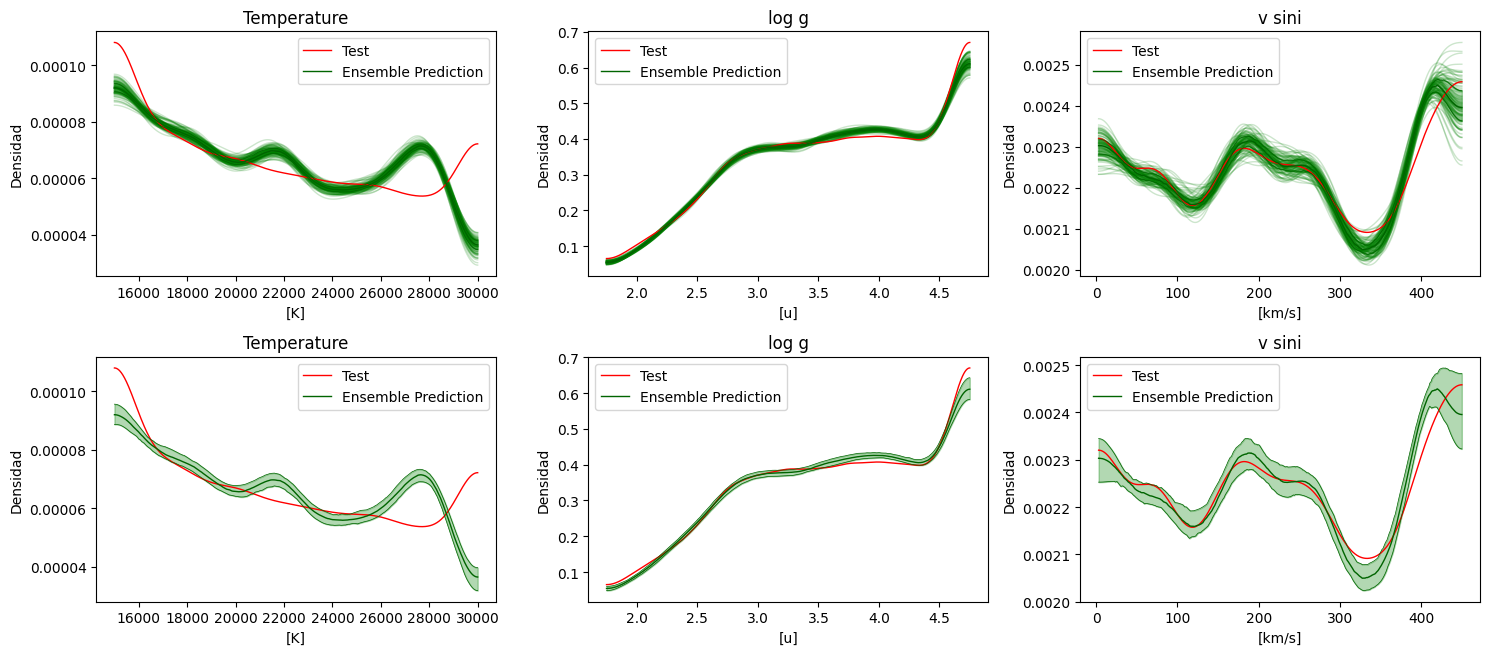

In [123]:
# Ref: https://stackoverflow.com/questions/60130503/plotting-bars-hist-and-pdf-line-via-kdeplot
import scipy.stats as st
from scipy.interpolate import interp1d

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,6.66))

for i, featureName in enumerate(target):
	x_space = np.linspace(Y[featureName].min(), Y[featureName].max(), 2**12)
	heights = []
	for j in range(NUM_MODELS):
		prediction_y = y_scaler.inverse_transform(predictions[j,:,:]) # your data goes here
		prediction_y = prediction_y[:,i]
		x,y,prediction_kde = SKL_density_plot(prediction_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',alpha=0.2)
		f = interp1d(x, y, kind="linear", assume_sorted=True)
		h = f(x_space)*3
		heights.append(h)
  
	heights = np.array(heights)
 
	rescaled_y = y_scaler.inverse_transform(y_test)[:,i]
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[1,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	f = interp1d(x, y, kind="linear", assume_sorted=True)
	test_h = f(x_space)
 
	# cuantiles 50% de los datos
	q25 = np.quantile(heights,0.25,axis=0)
	q75 = np.quantile(heights,0.75,axis=0)
	axes[0,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[0,i].plot(x_space, q25,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].plot(x_space, q75,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].fill_between(x_space, q25,q75, alpha=0.30, color='green')
	
	# cuantiles 95% de los datos
	q5 = np.quantile(heights,0.05,axis=0)
	q95 = np.quantile(heights,0.95,axis=0)
	axes[1,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[1,i].plot(x_space, q5,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].plot(x_space, q95,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].fill_between(x_space, q5,q95, alpha=0.30, color='green')
	
	measure = ['Temperature','log g', 'v sini']
	measure_unit = ['[K]', '[u]', '[km/s]']
	axes[1,i].set_xlabel(measure_unit[i])
	axes[1,i].set_ylabel('Densidad')
	axes[1,i].legend()
	axes[1,i].set_title(measure[i])

	axes[0,i].set_xlabel(measure_unit[i])
	axes[0,i].set_ylabel('Densidad')
	axes[0,i].legend()
	axes[0,i].set_title(measure[i])


plt.tight_layout()
plt.show()

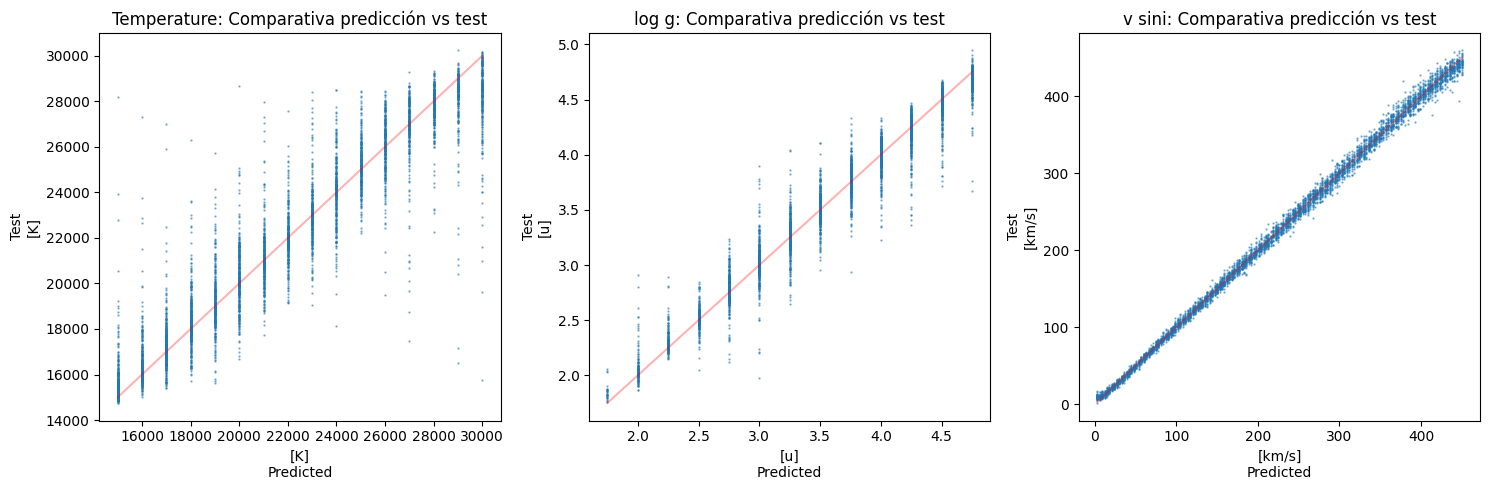

In [124]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=ensemble_prediction[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Comparativa predicción vs test')
 
plt.tight_layout();
plt.show()

c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\monte\

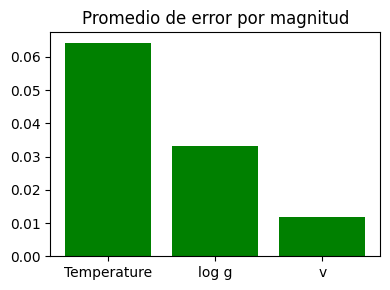

In [298]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
x_data = ['Temperature','log g','v']

diff = np.mean(np.array([np.abs(y_scaler.transform(y_hat)-y_test) for y_hat in predictions]),axis=(0,1))
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error por magnitud')
plt.tight_layout()
plt.show()


In [126]:
# / TODO Error relativo-absoluto agregado en la tabla
# / TODO scatter de valor esperado sobre prediccion
# / TODO graficar comparativa entre estrella sitentica y real
# / TODO grafica con vecindario de espectro real

In [299]:
#data formatting
inverse_y_test = y_scaler.inverse_transform(y_test)
rel_error = np.abs(ensemble_prediction-inverse_y_test)*(1/inverse_y_test)*100
abs_error = np.abs(ensemble_prediction-inverse_y_test)

table_formatted_temperature = [str(np.round(i)) for i in np.round(inverse_y_test[:,0],0)]
table_formatted_log_g = [str(np.round(i,2)) for i in np.round(inverse_y_test[:,1],2)]
table_formatted_v = [str(int(np.round(i))) for i in np.round(inverse_y_test[:,2],0)]

table_formatted_temperature_pred = [str(np.round(i)) for i in ensemble_prediction[:,0]]
table_formatted_log_g_pred = [str(np.round(i,2)) for i in ensemble_prediction[:,1]]
table_formatted_v_pred = [str(int(np.round(i))) for i in ensemble_prediction[:,2]]

table_formatted_temperature_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(np.round(i,2))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(int(np.round(i)))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [300]:
# tabla de resultados modelo unico sobre datos observados

results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temp':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
                    })
Obs_df[['HD','date','time']].join(results).set_index('HD').head(20)

,date,time,Temperatura,Prediccion_Temp,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel)
HD,,,,,,,,,,,
33328,2012-11-13,05-37-18,17000.0,17609.0,609.0 (3.6%),3.25,3.22,0.03 (0.9%),246,248,2 (0.8%)
33328,2013-01-18,03-39-09,18000.0,16910.0,1090.0 (6.1%),2.75,2.76,0.01 (0.5%),285,287,2 (0.6%)
33328,2013-02-26,00-55-34,30000.0,27944.0,2056.0 (6.9%),3.75,3.59,0.16 (4.2%),267,263,4 (1.5%)
33328,2015-02-25,23-58-07,23000.0,22269.0,731.0 (3.2%),2.5,2.46,0.04 (1.5%),63,61,2 (2.8%)
33328,2015-02-26,00-19-03,19000.0,19706.0,706.0 (3.7%),3.0,3.03,0.03 (0.9%),126,126,0 (0.1%)
35165,2014-03-20,23-53-54,17000.0,17209.0,209.0 (1.2%),4.5,4.35,0.15 (3.4%),156,158,2 (1.3%)
35165,2014-03-21,00-14-49,28000.0,23216.0,4784.0 (17.1%),3.25,2.92,0.33 (10.1%),450,454,4 (0.8%)
35165,2014-03-21,00-35-18,22000.0,21061.0,939.0 (4.3%),4.0,4.07,0.07 (1.8%),285,291,6 (1.9%)
35165,2015-11-14,04-22-43,23000.0,23277.0,277.0 (1.2%),3.0,2.97,0.03 (1.0%),30,30,0 (1.3%)


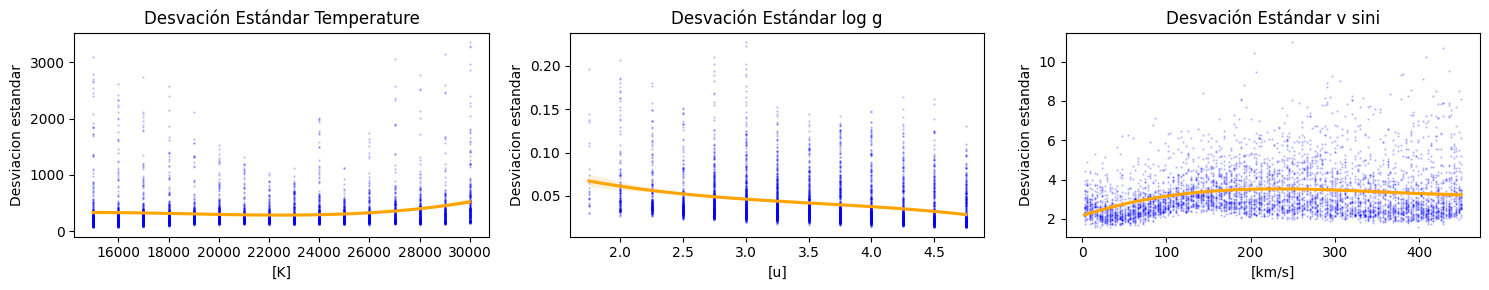

In [305]:
# dataframe
inverse_y_test = y_scaler.inverse_transform(y_test)
results = pd.DataFrame({
  'Temperatura':inverse_y_test[:,0],'Temp_pred':ensemble_prediction[:,0],'Temp_Variance':uncertainty[:,0],
  'log_g':inverse_y_test[:,1],'log_g_pred':ensemble_prediction[:,1],'log_g_Variance':uncertainty[:,1],
  'v':inverse_y_test[:,2],'v_pred':ensemble_prediction[:,2],'v_Variance':uncertainty[:,2]
                    })
# TODO: algo que permita ver el tamano de las varianzas sobre target feature
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
feat=['Temperatura', 'log_g',	'v']
vari=['Temp_Variance','log_g_Variance','v_Variance']
measure = ['Temperature','log g', 'v sini']
measure_unit = ['[K]', '[u]', '[km/s]']

for i, featureName in enumerate(target):
	x_data = y_scaler.inverse_transform(y_test)[:,i]
	y_data = uncertainty[:,i]
	sns.regplot(x=feat[i], y=vari[i], data=results,ax=axes[i],scatter_kws=dict(alpha=0.2,color='blue',s=0.5),line_kws=dict(color='orange'), order=3);
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel("Desviacion estandar")
	axes[i].set_title('Desvación Estándar '+measure[i])
	#axes[i].legend()
  
plt.tight_layout()
plt.show()

### Datos observados vs predicción (ensamble)

In [285]:
weights_fp = open('./data/weights.txt','r')
weights = []
predictions = []
for i in range(NUM_MODELS):
    weights.append([1-float(weights_fp.readline().split()[0])])
    test_predictions_fp = open('./data/obs/'+str(i)+'.predictions.txt','r')
    predictions.append(y_scaler.inverse_transform(read_predictions(test_predictions_fp,len(X_obs))))

weights = np.array(weights)
predictions = np.array(predictions)#.reshape((NUM_MODELS, len(x_test),len(target)))

In [286]:
# prediccion del ensamble e incerteza
weights = [(weight)/sum(weights) for weight in weights]

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(NUM_MODELS)])
uncertainty = sum([(ensemble_prediction-predictions[i])**2*weights[i] for i in range(NUM_MODELS)])**(1/2)

### Individual ensemble metrics(observed data)

In [287]:
# metricas por parametro
losses = []
maes = []
predictions = y_scaler.transform(ensemble_prediction)

for i in range(len(target)):
  losses.append(np.mean((predictions[:,i]-y_obs[:,i])**2))
  maes.append(np.mean(np.abs(predictions[:,i]-y_obs[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.191  MAE:0.366
log g -       loss: 0.046  MAE:0.183
v -           loss: 0.027  MAE:0.104


c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


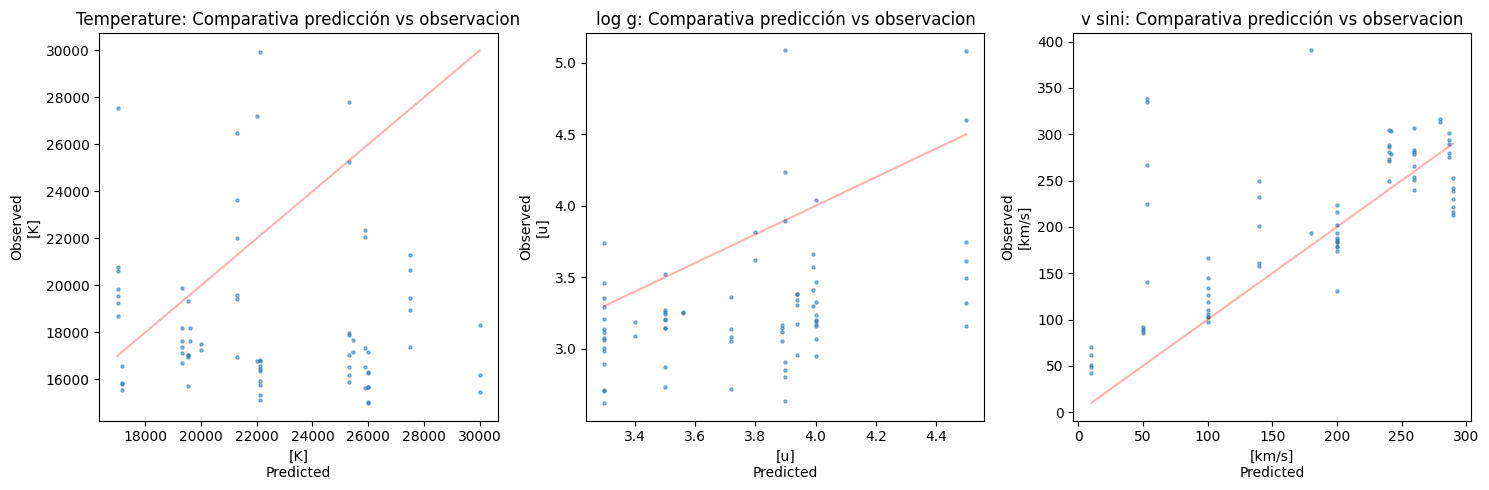

In [288]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_obs)[:,i].min(), y_scaler.inverse_transform(y_obs)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_obs)[:,i],y=ensemble_prediction[:,i],s=5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Observed\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Comparativa predicción vs observacion')
 
plt.tight_layout();
plt.show()

In [289]:
# data processing for formatted table

# error sign: ±

table_formatted_temperature_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,0],uncertainty[:,0])]
table_formatted_log_g_pred = [str(round(i,2))+' ± '+str(round(j,2)) for i,j in zip(ensemble_prediction[:,1],uncertainty[:,1])]
table_formatted_v_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,2],uncertainty[:,2])]

#data formatting
inverse_y_obs = y_scaler.inverse_transform(y_obs)
rel_error = np.abs(ensemble_prediction-inverse_y_obs)*(1/inverse_y_obs)*100
abs_error = np.abs(ensemble_prediction-inverse_y_obs)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_obs[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_obs[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_obs[:,2],0)]

table_formatted_temperature_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(np.round(i,2))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [294]:
# dataframe comparativo de datos observados
inverse_y_obs = y_scaler.inverse_transform(y_obs)
results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temperatura':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
  'paramCloseXi': table_formatted_xi
                    })
Obs_df[['HD','date','time']].join(results).set_index('HD').head(60)

,date,time,Temperatura,Prediccion_Temperatura,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel),paramCloseXi
HD,,,,,,,,,,,,
33328,2012-11-13,05-37-18,19526,16946 ± 281,2580.0 (13.2%),3.3,3.21 ± 0.09,0.09 (2.8%),287,280 ± 6,7.0 (2.6%),100.145347
33328,2013-01-18,03-39-09,19526,15704 ± 316,3822.0 (19.6%),3.3,3.74 ± 0.19,0.44 (13.4%),287,276 ± 7,11.0 (3.9%),88.230602
33328,2013-02-26,00-55-34,19526,19316 ± 398,210.0 (1.1%),3.3,3.12 ± 0.04,0.18 (5.6%),287,302 ± 5,15.0 (5.1%),93.982720
33328,2015-02-25,23-58-07,19526,17034 ± 1111,2492.0 (12.8%),3.3,3.06 ± 0.17,0.24 (7.2%),287,294 ± 20,7.0 (2.3%),116.914635
33328,2015-02-26,00-19-03,19526,17044 ± 685,2482.0 (12.7%),3.3,3.3 ± 0.15,0.0 (0.1%),287,289 ± 14,2.0 (0.8%),111.190865
35165,2014-03-20,23-53-54,17000,19253 ± 1688,2253.0 (13.3%),4.0,3.23 ± 0.23,0.77 (19.1%),240,271 ± 27,31.0 (13.0%),175.906493
35165,2014-03-21,00-14-49,17000,19543 ± 1354,2543.0 (15.0%),4.0,3.46 ± 0.2,0.54 (13.4%),240,273 ± 24,33.0 (13.8%),172.360638
35165,2014-03-21,00-35-18,17000,18675 ± 1332,1675.0 (9.9%),4.0,3.33 ± 0.2,0.67 (16.8%),240,250 ± 20,10.0 (4.0%),172.762155
35165,2015-11-14,04-22-43,17000,20608 ± 661,3608.0 (21.2%),4.0,3.2 ± 0.1,0.8 (19.9%),240,286 ± 15,46.0 (19.1%),162.566641


In [ ]:
# total execution time print
execution_time = float(time.time() - start_time)
print_time(execution_time)

--- Total: 14 hours, 22 minutes, 21.224026 seconds  ---
